Install dependencies:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap xgboost lightgbm scikit-learn pandas matplotlib seaborn catboost dask[dataframe]

In [12]:
# -------------------------------
# Security ML Pipeline v1.0
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import os
import pprint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, recall_score,
                             precision_score, roc_auc_score, r2_score)
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Configuration
MODEL_DIR = "/content/drive/MyDrive/SYLLABUS PCCOE/3rd Year Syllabus/Sem-VI Syllabus/TS/Technical Seminar 6th sem/TS_FInal/Demo/security_models"
# Create the directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

METRICS_FILE = "model_performance.csv"
np.random.seed(42)

In [15]:
# -------------------------------
# Phase 1: Data Preparation
# -------------------------------
print("Loading and preprocessing data...")
df = pd.read_excel('/content/drive/MyDrive/SYLLABUS PCCOE/3rd Year Syllabus/Sem-VI Syllabus/TS/Technical Seminar 6th sem/TS_FInal/Demo/AccessLogWeb.xlsx', engine='openpyxl')
df.head()


Loading and preprocessing data...


,ip,datetime,gmt,request,status,size,referer,browser,country,detected
0,114.125.221.132,2019-07-01 10:54:15,+0700],GET /bkd_baru/assets/images/scan_sertifikat/D0...,200.0,12133,http://universitas.com/bkd_baru/assets/images/...,Mozilla/5.0 (Linux; Android 5.1.1; SM-J111F Bu...,Indonesia,BAHAYA
1,114.125.221.132,2019-07-01 10:54:23,+0700],GET /bkd_baru/assets/images/scan_sertifikat/D0...,200.0,15491,http://universitas.com/bkd_baru/assets/images/...,Mozilla/5.0 (Linux; Android 5.1.1; SM-J111F Bu...,Indonesia,BAHAYA
2,114.125.221.132,2019-07-01 10:54:42,+0700],POST /bkd_baru/assets/images/scan_sertifikat/D...,200.0,16305,http://universitas.com/bkd_baru/assets/images/...,Mozilla/5.0 (Linux; Android 5.1.1; SM-J111F Bu...,Indonesia,BAHAYA
3,114.125.221.132,2019-07-01 10:55:08,+0700],GET /bkd_baru/uwubahon.php HTTP/1.1,404.0,1130,-,Mozilla/5.0 (Linux; Android 5.1.1; SM-J111F Bu...,Indonesia,BAHAYA
4,114.125.221.132,2019-07-01 10:55:28,+0700],GET /bkd_baru/awubahon.php HTTP/1.1,200.0,1735,-,Mozilla/5.0 (Linux; Android 5.1.1; SM-J111F Bu...,Indonesia,BAHAYA


In [16]:
# Handle missing values
df['request'] = df['request'].fillna('UNKNOWN')
df['status'] = df['status'].fillna(df['status'].mode()[0]).astype(int)
df['size'] = pd.to_numeric(df['size'].str.replace('-', '0'), errors='coerce').fillna(0).astype(int)
df['referer'] = df['referer'].fillna('UNKNOWN')
df['browser'] = df['browser'].fillna('UNKNOWN')

# Feature engineering
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday

# Encode target
le = LabelEncoder()
df['detected'] = le.fit_transform(df['detected'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Encode categorical features
# Replace spaces and special characters in the dummy variable column names
df = pd.get_dummies(df, columns=['country', 'browser'], drop_first=True, prefix_sep='_')
df = df.rename(columns=lambda x: x.replace(' ', '_').replace('[', '_').replace(']', '_')
               .replace('<', '_').replace('>', '_').replace('{', '_').replace('}', '_')
               .replace('(', '_').replace(')', '_').replace('!', '_').replace('@', '_')
               .replace('#', '_').replace('$', '_').replace('%', '_').replace('^', '_')
               .replace('&', '_').replace('*', '_').replace('+', '_').replace('=', '_')
               .replace(':', '_').replace(';', '_').replace('"', '_').replace("'", '_')
               .replace(',', '_').replace('.', '_').replace('/', '_').replace('?', '_')
               .replace('\\', '_').replace('|', '_').replace('~', '_').replace('`', '_'))

# Prepare features
drop_columns = ['ip', 'datetime', 'gmt', 'request', 'referer', 'detected']
X = df.drop(columns=drop_columns)
y = df['detected']

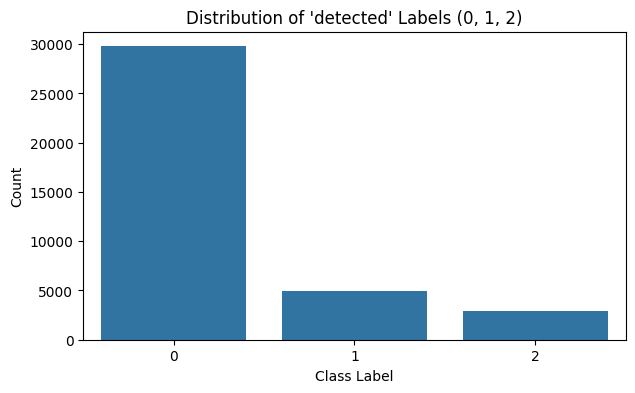

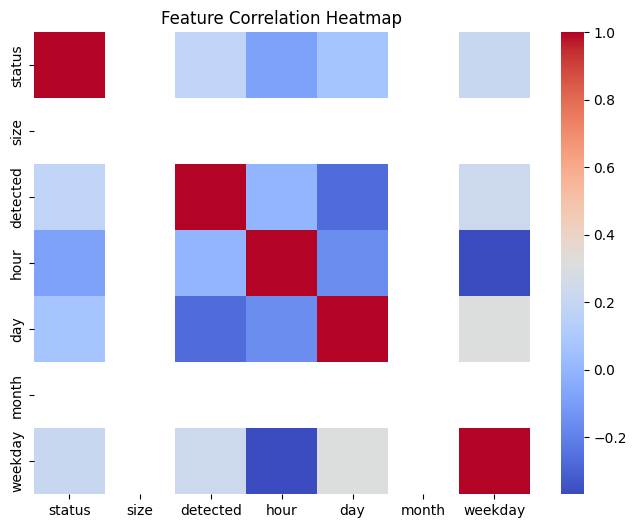

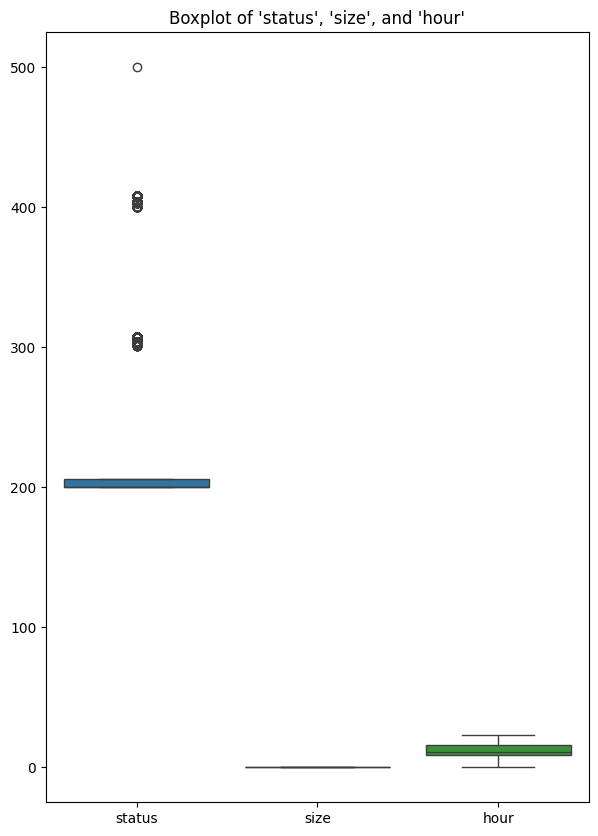

In [5]:
# -------------------------------
# Data Visualization for EDA
# -------------------------------
# 1. Target Distribution
plt.figure(figsize=(7, 4))
sns.countplot(x=df['detected'])
plt.title("Distribution of 'detected' Labels (0, 1, 2)")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(8, 6))
# Select only numerical features for correlation
numerical_df = df.select_dtypes(include=np.number)
corr = numerical_df.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. (Optional) Visualize some numerical features distributions
plt.figure(figsize=(7, 10))
sns.boxplot(data=df[['status', 'size', 'hour']])
plt.title("Boxplot of 'status', 'size', and 'hour'")
plt.show()

In [6]:
def feature_selection(X, y, sample_size=1000, n_estimators=50):
    """
    Performs SHAP-based feature selection using a baseline RandomForest model.
    Uses a subset of the data for faster training and SHAP computation.

    Parameters:
        X (pd.DataFrame): The feature matrix.
        y (pd.Series or array-like): The target variable.
        sample_size (int): Number of samples to use for both training and SHAP computation.
        n_estimators (int): Number of trees for the RandomForestClassifier.

    Returns:
        List[str]: A list of selected feature names whose average absolute SHAP value
                   exceeds the 75th percentile.
    """
    # Use a sample for training and SHAP computation if the dataset is large
    if X.shape[0] > sample_size:
        X_sample = X.sample(n=sample_size, random_state=42)
        y_sample = y.loc[X_sample.index]
    else:
        X_sample = X.copy()
        y_sample = y.copy()

    # Train a baseline RandomForest model with reduced n_estimators and parallel processing
    baseline = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    baseline.fit(X_sample, y_sample)

    # Create a SHAP TreeExplainer with interventional feature perturbation
    # Set model_output="raw" for compatibility.
    explainer = shap.TreeExplainer(baseline, feature_perturbation='interventional', model_output="raw")

    # Compute SHAP values on the sample, disabling the additivity check.
    shap_values = explainer.shap_values(X_sample, check_additivity=False)

    # Process the SHAP values:
    # If shap_values is a list, convert to an array.
    if isinstance(shap_values, list):
        shap_values = np.array(shap_values)

    # If the SHAP values have three dimensions (n_samples, n_features, n_classes),
    # average over the class dimension.
    if shap_values.ndim == 3:
        shap_abs = np.mean(np.abs(shap_values), axis=2)
    else:
        shap_abs = np.abs(shap_values)

    # Create a DataFrame of SHAP values using the correct sample columns.
    shap_df = pd.DataFrame(shap_abs, columns=X_sample.columns)

    # Calculate the mean absolute SHAP value per feature and sort them.
    importance = shap_df.mean().sort_values(ascending=False)

    # Select features with importance above the 75th percentile.
    threshold = importance.quantile(0.75)
    selected_features = importance[importance > threshold].index.tolist()

    return selected_features

# -------------------------------
# Example usage:
# -------------------------------
print("Performing SHAP-based feature selection...")
selected_features = feature_selection(X, y, sample_size=1000, n_estimators=50)
print("Selected features count:", len(selected_features))
print("Selected features:", selected_features)


Performing SHAP-based feature selection...
Selected features count: 70
Selected features: ['country_Indonesia', 'day', 'country_United_States', 'weekday', 'hour', 'status', 'browser_Mozilla_5_0__Windows_NT_6_3__rv_68_0__Gecko_20100101_Firefox_68_0', 'browser_Mozilla_5_0__Windows_NT_10_0__Win64__x64__AppleWebKit_537_36__KHTML__like_Gecko__Chrome_75_0_3770_142_Safari_537_36', 'browser_Mozilla_5_0__Linux__Android_8_0_0__SM-J400F_Build_R16NW__AppleWebKit_537_36__KHTML', 'country_Germany', 'browser_Mozilla_5_0__Windows_NT_6_1__AppleWebKit_537_36__KHTML__like_Gecko__Chrome_75_0_3770_142_Safari_537_36', 'browser_Mozilla_5_0__Windows_NT_6_1__rv_68_0__Gecko_20100101_Firefox_68_0', 'browser_Mozilla_5_0__Windows_NT_6_1__WOW64__AppleWebKit_537_36__KHTML__like_Gecko__Chrome_75_0_3770_142_Safari_537_36', 'country_Hong_Kong', 'browser_Mozilla_5_0__Linux__Android_9__SM-J400F__AppleWebKit_537_36__KHTML__like_Gecko__Chrome_72_0_3626_121_Mobile_Safari_537_36', 'browser_Mozilla_4_0__compatible__MSIE_9_0__

In [7]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42, stratify=y # Use X[selected_features]
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 30154 samples
Test set: 7539 samples


In [8]:
# -------------------------------
# Phase 3: Optimized Model Configurations
# -------------------------------
model_configs = {
    'ThreatDetect_RF': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {
            'n_estimators': [200, 300, 400, 500],
            'max_depth': [15, 20, None],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 0.8]
        },
        'calibrate': True
    },
    'ThreatDetect_XGB': {
        'model': XGBClassifier(scale_pos_weight=1, eval_metric='mlogloss'),
        'params': {
            'learning_rate': [0.05, 0.1],
            'max_depth': [5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'calibrate': False
    },
    'ThreatDetect_LGBM': {
        'model': LGBMClassifier(class_weight='balanced'),
        'params': {
            'num_leaves': [31, 63],
            'learning_rate': [0.05, 0.1],
            'max_depth': [5, 7, 10],
            'min_data_in_leaf': [30, 50, 100]
        },
        'calibrate': True
    }
}

In [9]:
# -------------------------------
# Phase 4: Advanced Training Pipeline & Model Evaluation
# -------------------------------
performance_records = {}
best_models = {}  # To store each model after tuning

def security_evaluator(y_true, y_pred, y_proba=None):
    # Note: R2 is not typically used for classification.
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred, average='weighted'),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'R2': r2_score(y_true, y_pred)  # Included for completeness, but interpret with caution
    }
    if y_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_proba, multi_class='ovo')
    return metrics

from sklearn.model_selection import RandomizedSearchCV

for model_name, config in model_configs.items():
    print(f"\n⚙️ Training {model_name}...")

    search = RandomizedSearchCV(
        estimator=config['model'],
        param_distributions=config['params'],
        n_iter=15,
        scoring='f1_weighted',
        n_jobs=-1,
        cv=3,
        random_state=42
    )
    search.fit(X_train, y_train)

    best_estimator = search.best_estimator_
    best_estimator.fit(X_train, y_train)

    if config['calibrate']:
        final_model = CalibratedClassifierCV(best_estimator, cv='prefit')
        final_model.fit(X_train, y_train)
    else:
        final_model = best_estimator

    y_pred = final_model.predict(X_test)
    y_proba = final_model.predict_proba(X_test) if hasattr(final_model, "predict_proba") else None
    metrics = security_evaluator(y_test, y_pred, y_proba)

    performance_records[model_name] = {
        **metrics,
        'Best_Params': search.best_params_
    }

    best_models[model_name] = final_model  # Store the final model
    print(f"{model_name} best parameters: {search.best_params_}")
    print(f"{model_name} test accuracy: {metrics['Accuracy']:.4f}")


⚙️ Training ThreatDetect_RF...
ThreatDetect_RF best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}
ThreatDetect_RF test accuracy: 0.9956

⚙️ Training ThreatDetect_XGB...
ThreatDetect_XGB best parameters: {'subsample': 0.8, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
ThreatDetect_XGB test accuracy: 0.9946

⚙️ Training ThreatDetect_LGBM...
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 30154, number of used fea


--- Performance Comparison ---
               Model  Accuracy        F1 Precision    Recall        R2  \
0    ThreatDetect_RF  0.995623  0.995637  0.995673  0.995623  0.986797   
1   ThreatDetect_XGB  0.994562  0.994575  0.994602  0.994562  0.983863   
2  ThreatDetect_LGBM  0.995225  0.995246  0.995306  0.995225  0.985697   

    ROC-AUC                                        Best_Params  
0  0.999916  {'n_estimators': 300, 'min_samples_split': 2, ...  
1  0.999909  {'subsample': 0.8, 'max_depth': 7, 'learning_r...  
2   0.99992  {'num_leaves': 63, 'min_data_in_leaf': 30, 'ma...  


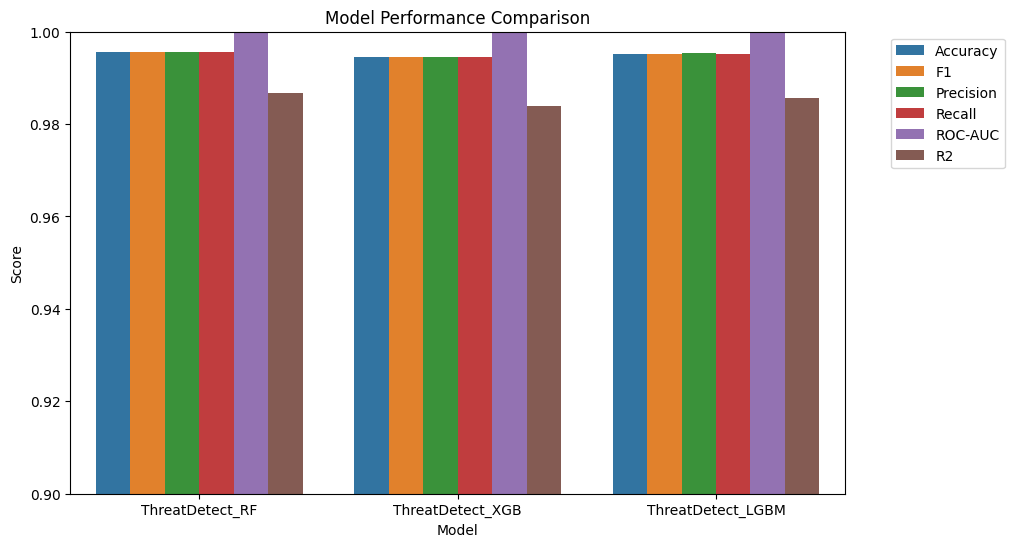

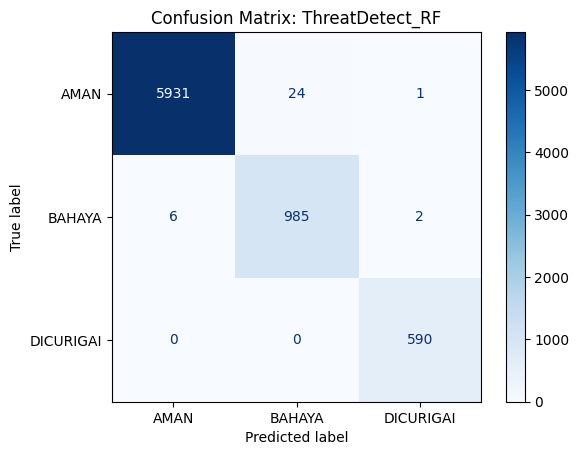

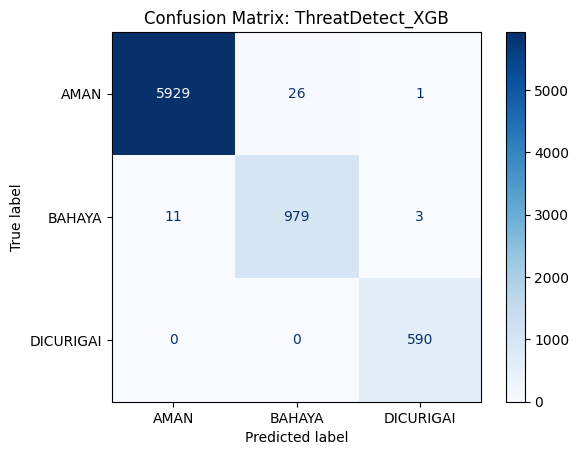

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


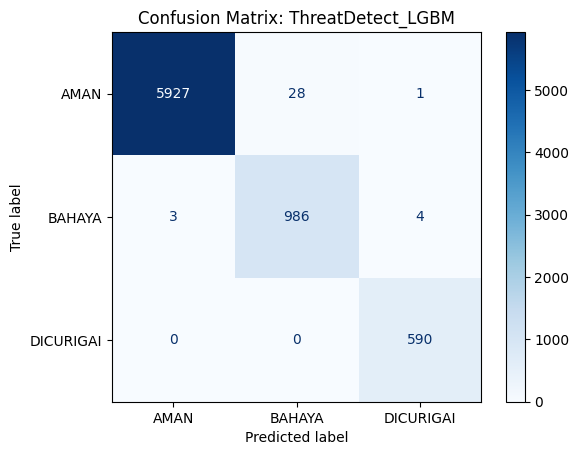

In [10]:
# -------------------------------
# Phase 5: Visualization & Model Comparison
# -------------------------------
# Convert performance records to a DataFrame for visualization.
perf_df = pd.DataFrame(performance_records).T.reset_index().rename(columns={'index': 'Model'})
print("\n--- Performance Comparison ---")
print(perf_df)

# Bar plot comparing Accuracy, F1, Precision, Recall, ROC-AUC, and R2 across models.
metrics_to_plot = ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC-AUC', 'R2']
perf_melt = perf_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=perf_melt)
plt.title("Model Performance Comparison")
plt.ylim(0.90, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Optionally, display confusion matrices for each model.
from sklearn.metrics import ConfusionMatrixDisplay

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

In [13]:
# -------------------------------
# Phase 6: Best Model Selection & Saving
# -------------------------------
# Select the best model based on Accuracy (or any metric of your choice)
best_model_name = perf_df.loc[perf_df['Accuracy'].idxmax(), 'Model']
print(f"Best model based on Accuracy: {best_model_name}")

# Save the best model using joblib
best_model = best_models[best_model_name]
model_filename = f"{MODEL_DIR}/{best_model_name}_v1.pkl"
joblib.dump(best_model, model_filename)
print(f"Best model saved as: {model_filename}")

Best model based on Accuracy: ThreatDetect_RF
Best model saved as: /content/drive/MyDrive/SYLLABUS PCCOE/3rd Year Syllabus/Sem-VI Syllabus/TS/Technical Seminar 6th sem/TS_FInal/Demo/security_models/ThreatDetect_RF_v1.pkl
